# Analyze RAGIS ensmbles

In [63]:
from datetime import datetime
import numpy as np
import pylab as plt
import pandas as pd
from pathlib import Path
import os

import seaborn as sns

from pismragis.observations import load_imbie, load_mouginot
from pismragis.analysis import resample_ensemble_by_data, sensitivity_analysis
from pismragis.processing import convert_netcdf_to_dataframe, check_file, copy_file, to_decimal_year
from pismragis.stats import run_stats

## Some settings

In [64]:
def load_mankoff(discharge_url: Union[str, Path] = Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/gate_D.csv"),
                 discharge_error_url: Union[str, Path] = Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/gate_err.csv"),     
):
    m_df = pd.read_csv(discharge_url, parse_dates=["Date"], infer_datetime_format=True)
    d_df = pd.read_csv(discharge_url, parse_dates=["Date"], infer_datetime_format=True)
    de_df = pd.read_csv(discharge_error_url, parse_dates=["Date"], infer_datetime_format=True)
    d_df = -d_df.drop(columns="Date").sum(axis=1)
    d_df.name = "D (Gt/yr)"
    de_df = de_df.drop(columns="Date").apply(np.square).sum(axis=1).apply(np.sqrt)
    de_df.name = "D uncertainty (Gt/yr)"
    df = pd.merge(d_df, de_df,  left_index=True, right_index=True)
    df["Date"] = m_df["Date"]
    df["Year"] = [to_decimal_year(d) for d in df["Date"]]
    return df


In [65]:
# Root directory
data_dir = Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism")
assert data_dir.exists()
results_dir = "2023_10_tw_ocean_calving_analyis"
o_dir = data_dir / results_dir
o_dir.mkdir(exist_ok=True)
fig_dir = o_dir / "figures"
fig_dir.mkdir(exist_ok=True)
# Number of parallel jobs
n_jobs = 4
# Normalization year (1992 IMBIE)
norm_year = 1992

In [66]:

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

mass_varname = "SLE (cm)"
mass_uncertainty_varname = "SLE uncertainty (cm)"
discharge_varname = "D (Gt/yr)"
discharge_uncertainty_varname = "D uncertainty (Gt/yr)"
smb_varname = "SMB (Gt/yr)"
smb_uncertainty_varname = "SMB uncertainty (Gt/yr)"

bg_color = "w"
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

sim_colors = [ "#d73027",  "#4575b4", "#fc8d59", "#91bfdb", "#fee090"]

imbie_color = "#756bb1"
mou_color = "#54278f"

imbie_color = "0.4"
man_color = "0.3"
mou_color = "0.2"

    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0

## Load Observations

In [67]:
# imbie = load_imbie(url=Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/imbie_dataset_greenland_dynamics-2020_02_28.xlsx"))
imbie = load_imbie()
# Glacier and Ice cap bias 30 Gt/yr, add it back
imbie[mass_varname] -= 30 * gt2cmsle
imbie[smb_varname] += 30

mou = load_mouginot(url=Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx"), norm_year=1980)
mou_gis = mou[mou["Basin"] == "GIS"]

mou_1992 = load_mouginot(url=Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx"), norm_year=1992)
mou_gis_1992 = mou_1992[mou_1992["Basin"] == "GIS"]

man = load_mankoff()

## Make a list of all experiments

In [68]:
exps = []

# exps.append({
#     "Experiment": "GrIMP",
#     "proj_dir": "2023_10_grimp_ocean_calving_w_posterior_lhs_50",
#     "scalar_dir": "scalar",
#     "processed_dir": "processed",
#     "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
#     "DEM": "GRIMP"
# }
# )



# exps.append({
#     "Experiment": "RAGIS",
#     "proj_dir": "2023_10_ragis_ocean_calving_w_posterior_lhs_50",
#     "scalar_dir": "scalar",
#     "processed_dir": "processed",
#     "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
#     "DEM": "RAGIS"
# }
# )

exps.append({
    "Experiment": "GrIMP",
    "proj_dir": "2023_10_grimp_tw_ocean_calving_w_posterior_lhs_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
    "DEM": "GRIMP"
}
)



exps.append({
    "Experiment": "RAGIS",
    "proj_dir": "2023_10_ragis_tw_ocean_calving_w_posterior_lhs_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
    "DEM": "RAGIS"
}
)


## Process experiments

In [69]:
experiments = []

for exp in exps:
    print(f"""Processing {exp["Experiment"]}""")
    print("================================================\n")
    ens_file = data_dir / exp["proj_dir"] / "uq" /f"""{exp["lhs"]}.csv"""
    s_dir = data_dir / exp["proj_dir"] / exp["scalar_dir"]
    scalar_files = sorted(s_dir.glob(f"""ts_gris_g*00m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc"""))
    processed_path = data_dir / exp["proj_dir"] / exp["processed_dir"]
    for scalar_file in scalar_files:
        if check_file(scalar_file):
            copy_file(scalar_file, processed_path)
        
    processed_files = sorted(processed_path.glob(f"""ts_gris_g*00m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc"""))
    exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs, norm_year=1980)
    exp_df["Experiment"] = exp["Experiment"]
    exp["data_df"] = exp_df
    exp["run_stats"] = run_stats(processed_files, experiment=exp["Experiment"])
    try:
        sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
        exp["sensitivity_df"] = sa_df
    except:
        pass
    experiments.append(exp)


Processing GrIMP

/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_grimp_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_GRIMP_id_46_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|███████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.85it/s]


Conversion finished in 2 seconds
-------------------------------------------
-------------------------------------------

Processing RAGIS

/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_10_ragis_tw_ocean_calving_w_posterior_lhs_50/scalar/ts_gris_g900m_v2023_RAGIS_id_46_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|███████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 13.50it/s]


Conversion finished in 1 seconds
-------------------------------------------
-------------------------------------------



Peformace Summary for Experiment GrIMP (16 members)
---------------------------------------------------

processor_hours                   46767.850139
wall_clock_hours                    389.732084
model_years_per_processor_hour        0.012246
dtype: float64
---------------------------------------------------

Peformace Summary for Experiment RAGIS (18 members)
---------------------------------------------------

processor_hours                   47730.246332
wall_clock_hours                    397.752053
model_years_per_processor_hour        0.013632
dtype: float64
---------------------------------------------------



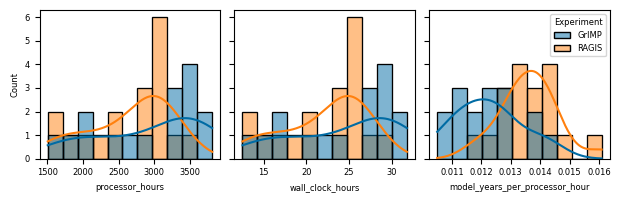

In [70]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

e = experiments[0]["run_stats"]
m_vars = ["processor_hours", "wall_clock_hours", "model_years_per_processor_hour"]
for m in range(len(experiments)):
    e_df = experiments[m]["run_stats"]
    print(f"""Peformace Summary for Experiment {experiments[m]["Experiment"]} ({len(e_df)} members)""")
    print("---------------------------------------------------\n")
    print(e_df.agg({'processor_hours': 'sum', 'wall_clock_hours': "sum", "model_years_per_processor_hour": "mean"}))
    print("---------------------------------------------------\n")

fig, axs = plt.subplots(nrows=1, ncols=len(m_vars), sharey="row", figsize=[6.2, 2.0])
fig.subplots_adjust(wspace=0)


all_run_stats = pd.concat([experiments[k]["run_stats"] for k in range(len(experiments))]).reset_index(drop=True)
[sns.histplot(data=all_run_stats, x=m_var, bins=11, kde=True, hue="Experiment", ax=axs[k]) for k, m_var in enumerate(m_vars)]
axs[0].legend([], [], frameon=False)
axs[1].legend([], [], frameon=False)


fig.tight_layout()
run_stats_file = fig_dir / "run_stats.pdf"
fig.savefig(run_stats_file)

## Plot

Plot time series of cumulative mass change (cm SLE) and discharge at grounding line (Gt/yr)

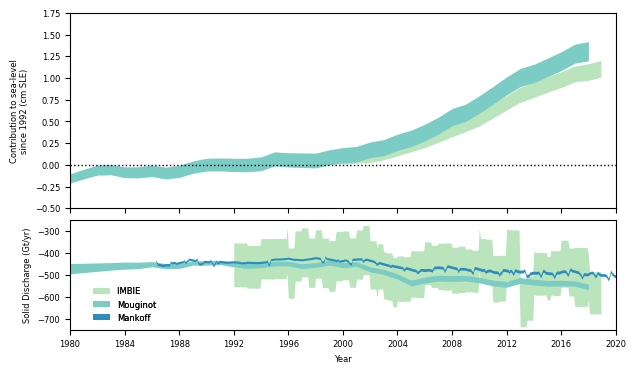

In [71]:
sigma = 1
sigma_mass = 1 
sigma_discharge = 1

imbie_color = "#bae4bc"
mou_color = "#7bccc4"
man_color = "#2b8cbe"

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 3.6), height_ratios=[16, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.1, top=0.98, left=0.1, right=0.98)

for obs, o, obs_color, obs_loc, obs_alpha  in zip([imbie, mou_gis_1992, man], ["IMBIE ", "Mouginot", "Mankoff"], 
                                       [imbie_color, mou_color, man_color], [(0.5, 0.0), (0.3, 0.0), (0.1, 0.0)], 
                                                  [1, 1, 1]):

    if mass_varname in obs:
        obs_ci = axs[0].fill_between(obs["Date"], 
                        (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                        (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                        ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=f"{sigma}-$\sigma$")
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)

legend_obs = axs[1].legend(loc="lower center", bbox_to_anchor=obs_loc)
legend_obs.get_frame().set_linewidth(0.0)
legend_obs.get_frame().set_alpha(0.0)
axs[1].add_artist(legend_obs)


    



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-0.5, 1.75)
axs[1].set_ylim(-750, -250)

# fig.tight_layout()
fig.savefig(fig_dir / "obs_1980-2020.pdf")
fig.savefig(fig_dir / "obs_1980-2020.png", dpi=600)

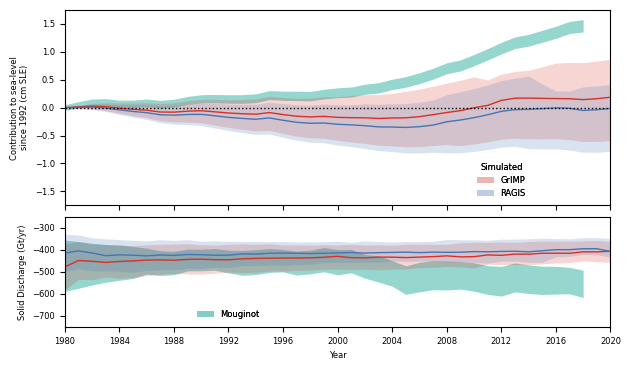

In [72]:
sigma_mass = 1 
sigma_discharge = 5


plot_experiments = experiments

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 3.6), height_ratios=[16, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.1, top=0.98, left=0.1, right=0.98)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot"], 
                                       [mou_color], [(0.3, 0.0)], [0.8]):
    obs_ci = axs[0].fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=f"{sigma}-$\sigma$")
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)


legend_obs = axs[1].legend(loc="lower center", bbox_to_anchor=obs_loc)
legend_obs.get_frame().set_linewidth(0.0)
legend_obs.get_frame().set_alpha(0.0)
axs[1].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_16 = df.groupby(by="time").quantile(0.16, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_84 = df.groupby(by="time").quantile(0.84, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=1)
    sims_ci = axs[0].fill_between(q_16.index, q_16[mass_varname], 
                        q_84[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_16.index, q_16[discharge_varname], 
                        q_84[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.8, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.75, 1.75)
axs[1].set_ylim(-750, -250)

# fig.tight_layout()
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2020.pdf")
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2020.png", dpi=600)

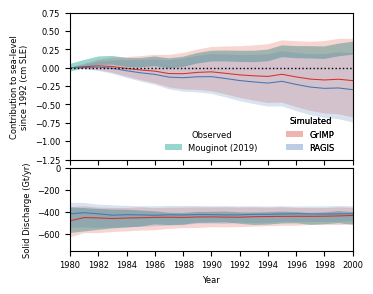

In [73]:
imbie[[discharge_uncertainty_varname]].mean() / mou_gis[[discharge_uncertainty_varname]].mean()
sigma_mass = 1
sigma_discharge = 5
plot_experiments = [experiments[0], experiments[1]]

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(3.6, 2.8), height_ratios=[16, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.125, top=0.975, left=0.175, right=0.96)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot (2019)"], 
                                       [mou_color], [(0.5, 0.0)], [0.8]):
    if mass_varname in obs:
        obs_ci = axs[0].fill_between(obs["Date"], 
                        (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                        (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                        ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)

    legend_obs = axs[0].legend(handles=[obs_ci], loc="lower center", bbox_to_anchor=obs_loc, 
                               title="Observed")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_05 = df.groupby(by="time").quantile(0.05, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_95 = df.groupby(by="time").quantile(0.95, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    sims_ci = axs[0].fill_between(q_05.index, q_05[mass_varname], 
                        q_95[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_05.index, q_05[discharge_varname], 
                        q_95[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.85, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    

fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.25, 0.75)
axs[1].set_ylim(-750, 0)

axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2000.pdf")
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2000.png", dpi=600)

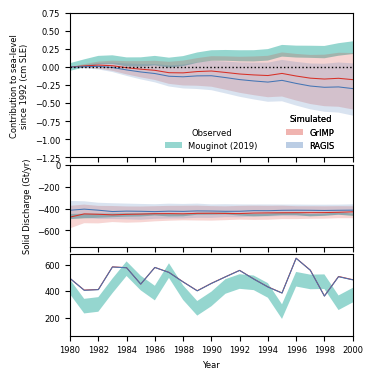

In [74]:
imbie[[discharge_uncertainty_varname]].mean() / mou_gis[[discharge_uncertainty_varname]].mean()
sigma_mass = 1
sigma_discharge = 1
sigma_smb = 1
plot_experiments = [experiments[0], experiments[1]]

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=(3.6, 3.8), height_ratios=[16, 9, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.125, top=0.975, left=0.175, right=0.96)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot (2019)"], 
                                       [mou_color], [(0.5, 0.0)], [0.8]):
    if mass_varname in obs:
        obs_ci = axs[0].fill_between(obs["Date"], 
                        (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                        (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                        ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)
    axs[2].fill_between(obs["Date"], 
                    (obs[smb_varname] + sigma_smb * obs[smb_uncertainty_varname]), 
                    (obs[smb_varname] - sigma_smb * obs[smb_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)

    legend_obs = axs[0].legend(handles=[obs_ci], loc="lower center", bbox_to_anchor=obs_loc, 
                               title="Observed")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_16 = df.groupby(by="time").quantile(0.16, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_84 = df.groupby(by="time").quantile(0.84, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[2].plot(q_50.index, q_50[smb_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    sims_ci = axs[0].fill_between(q_16.index, q_16[mass_varname], 
                        q_84[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_16.index, q_16[discharge_varname], 
                        q_84[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    axs[2].fill_between(q_16.index, q_16[smb_varname], 
                        q_84[smb_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.85, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    

fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.25, 0.75)
axs[1].set_ylim(-750, 0)

axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
fig.savefig(fig_dir / "ragis-comp-3_scalar_1980-2000.pdf")
fig.savefig(fig_dir / "ragis-comp-3_scalar_1980-2000.png", dpi=600)

## Plot sensitivity index

In [ ]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")


for e in experiments:
    sa_df = e["sensitivity_df"]
    si = "S1"
    outfile = f"""{e["DEM"]}_{e["lhs"]}.pdf"""
    fig, axs = plt.subplots(
        2,
        1,
        sharex="col",
        figsize=[6.2, 3.8],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["limnsw (kg)", "grounding_line_flux (Gt year-1)"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        ax = axs.ravel()[k]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        [
            ax.fill_between(
                p_df.index,
                p_df[v].values - p_conf_df[v].values,
                p_df[v].values + p_conf_df[v].values,
                alpha=0.2,
                lw=0,
            )
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]
        ax.set_xlim(datetime(1980, 1, 1), datetime(2020, 1, 1))
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = axs[-1].legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    o_file = fig_dir / f"{si}_{outfile}"
    fig.savefig(o_file)
    !open o_file

In [ ]:
m_e = experiments[0]["data_df"]
ragis_calib, weights = resample_ensemble_by_data(imbie, m_e, 
                                        fudge_factor=3, verbose=True)
calib_exps = ragis_calib["id"].unique()
print(calib_exps)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(12, 8))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

q_5 = ragis_calib.groupby(by="Year").quantile(0.05, numeric_only=True)
q_16 = ragis_calib.groupby(by="Year").quantile(0.16, numeric_only=True)
q_50 = ragis_calib.groupby(by="Year").quantile(0.50, numeric_only=True)
q_84 = ragis_calib.groupby(by="Year").quantile(0.84, numeric_only=True)
q_95 = ragis_calib.groupby(by="Year").quantile(0.95, numeric_only=True)
for exp in m_e:
    print(exp)
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], color="k", lw=1)
    print(e)
    axs[1].plot(e["Year"], e[discharge_varname], color="k", lw=1)

for exp in calib_exps:
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], lw=1)
    axs[1].plot(e["Year"], e[discharge_varname], lw=1)

axs[0].fill_between(q_50.index, q_16[mass_varname], q_84[mass_varname], color="w")
axs[0].fill_between(imbie["Year"], 
                    (imbie[mass_varname] + sigma * imbie[mass_uncertainty_varname]), 
                    (imbie[mass_varname] - sigma * imbie[mass_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, label="2-$\sigma$ IMBIE")
axs[1].fill_between(imbie["Year"], 
                    (imbie[discharge_varname] + sigma * imbie[discharge_uncertainty_varname]), 
                    (imbie[discharge_varname] - sigma * imbie[discharge_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, color=imbie_color)


axs[0].set_xlim(1992, 2020)
axs[0].set_ylim(0, 2)
fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)




In [ ]:
def resample_ensemble_by_data_o(
    observed: pd.DataFrame,
    simulated: pd.DataFrame,
    id_var: str = "id",
    calibration_start: float = 1992.0,
    calibration_end: float = 2017.0,
    fudge_factor: float = 3,
    n_samples: int = 100,
    verbose: bool = False,
    m_var: str = "Mass (Gt)",
    m_var_std: str = "Mass uncertainty (Gt)",
) -> pd.DataFrame:
    """
    Resampling algorithm by Douglas C. Brinkerhoff


    Parameters
    ----------
    observed : pandas.DataFrame
        A dataframe with observations
    simulated : pandas.DataFrame
        A dataframe with simulations
    calibration_start : float
        Start year for calibration
    calibration_end : float
        End year for calibration
    fudge_factor : float
        Tolerance for simulations. Calculated as fudge_factor * standard deviation of observed
    n_samples : int
        Number of samples to draw.

    """

    observed_calib_time = (observed["Year"] >= calibration_start) & (
        observed["Year"] <= calibration_end
    )
    observed_calib_period = observed[observed_calib_time]
    observed_interp_mean = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var]
    )
    observed_interp_std = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var_std]
    )
    simulated_calib_time = (simulated["Year"] >= calibration_start) & (
        simulated["Year"] <= calibration_end
    )
    simulated_calib_period = simulated[simulated_calib_time]

    resampled_list = []
    log_likes = []
    experiments = sorted(simulated_calib_period[id_var].unique())
    evals = []
    for i in experiments:
        exp_ = simulated_calib_period[(simulated_calib_period[id_var] == i)]
        exp_interp = interp1d(exp_["Year"], exp_[m_var])
        log_like = 0.0
        for year, observed_mean, observed_std in zip(
            observed_calib_period["Year"],
            observed_calib_period[m_var],
            observed_calib_period[m_var_std],
        ):
            try:
                observed_std *= fudge_factor
                exp_mean = exp_interp(year)

                log_like -= 0.5 * (
                    (exp_mean - observed_mean) / observed_std
                ) ** 2 + 0.5 * np.log(2 * np.pi * observed_std**2)
            except ValueError:
                pass
        if log_like != 0:
            evals.append(i)
            log_likes.append(log_like)
            if verbose:
                print(f"Experiment {i:.0f}: {log_like:.2f}")
    experiments = np.array(evals)
    w = np.array(log_likes)
    w -= w.mean()
    weights = np.exp(w)
    weights /= weights.sum()
    resampled_experiments = np.random.choice(experiments, n_samples, p=weights)
    new_frame = []
    for i in resampled_experiments:
        new_frame.append(simulated[(simulated[id_var] == i)])
    simulated_resampled = pd.concat(new_frame)
    resampled_list.append(simulated_resampled)

    simulated_resampled = pd.concat(resampled_list)

    return simulated_resampled


In [ ]:
def resample_ensemble_by_data(
    observed: pd.DataFrame,
    simulated: pd.DataFrame,
    id_var: str = "id",
    calibration_start: float = 1992.0,
    calibration_end: float = 2017.0,
    fudge_factor: float = 3,
    n_samples: int = 100,
    verbose: bool = False,
    m_var: str = "Mass (Gt)",
    m_var_std: str = "Mass uncertainty (Gt)",
) -> pd.DataFrame:
    """
    Resampling algorithm by Douglas C. Brinkerhoff


    Parameters
    ----------
    observed : pandas.DataFrame
        A dataframe with observations
    simulated : pandas.DataFrame
        A dataframe with simulations
    calibration_start : float
        Start year for calibration
    calibration_end : float
        End year for calibration
    fudge_factor : float
        Tolerance for simulations. Calculated as fudge_factor * standard deviation of observed
    n_samples : int
        Number of samples to draw.

    """

    observed_calib_time = (observed["Year"] >= calibration_start) & (
        observed["Year"] <= calibration_end
    )
    observed_calib_period = observed[observed_calib_time]
    observed_interp_mean = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var]
    )
    observed_interp_std = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var_std]
    )
    simulated_calib_time = (simulated["Year"] >= calibration_start) & (
        simulated["Year"] <= calibration_end
    )
    simulated_calib_period = simulated[simulated_calib_time]

    resampled_list = []
    log_likes = []
    experiments = sorted(simulated_calib_period[id_var].unique())
    evals = []
    for i in experiments:
        exp_ = simulated_calib_period[(simulated_calib_period[id_var] == i)]
        exp_interp = interp1d(exp_["Year"], exp_[m_var])
        log_like = 0.0
        for year, exp_mean in zip(exp_["Year"], exp_[m_var]):
            try:
                observed_mean = observed_interp_mean(year)
                observed_std = observed_interp_std(year) * fudge_factor
                log_like -= 0.5 * (
                    (exp_mean - observed_mean) / observed_std
                ) ** 2 + 0.5 * np.log(2 * np.pi * observed_std**2)
                print(i, year, f"{observed_mean:.3f}", f"{observed_std:.3f}", f"{exp_mean:.3f}")

            except ValueError:
                pass
        if log_like != 0:
            evals.append(i)
            log_likes.append(log_like)
            if verbose:
                print(f"Experiment {i:.0f}: {log_like:.2f}")
    experiments = np.array(evals)
    w = np.array(log_likes)
    w -= w.mean()
    weights = np.exp(w)
    weights /= weights.sum()
    resampled_experiments = np.random.choice(experiments, n_samples, p=weights)
    new_frame = []
    for i in resampled_experiments:
        new_frame.append(simulated[(simulated[id_var] == i)])
    simulated_resampled = pd.concat(new_frame)
    resampled_list.append(simulated_resampled)

    simulated_resampled = pd.concat(resampled_list)

    return simulated_resampled, weights

In [ ]:
uq_df = pd.read_csv("../uq/gris_ragis_calving_simple_lhs_50.csv")

In [ ]:
mou_gis.mean()

In [ ]:
gris_post = pd.read_csv("/Users/andy/base/pism-ragis/uq/X_gris_posterior_1e6_samples_11_2011.csv.gz")

In [ ]:
mankoff = load_mankoff()

man_de_df

In [ ]:
man_df

In [ ]:
man_de.apply?

In [3]:
from typing import Union

In [ ]:
pd.read_csv?

In [60]:
q_84[smb_varname]

time
1980-01-01    497.120902
1981-01-01    407.083288
1982-01-01    411.686467
1983-01-01    583.993831
1984-01-01    577.944241
1985-01-01    454.256268
1986-01-01    580.415980
1987-01-01    542.352730
1988-01-01    470.731750
1989-01-01    402.850087
1990-01-01    458.931345
1991-01-01    509.190835
1992-01-01    557.786464
1993-01-01    492.297445
1994-01-01    432.299174
1995-01-01    385.880257
1996-01-01    650.037533
1997-01-01    559.010908
1998-01-01    362.992960
1999-01-01    510.323071
2000-01-01    486.386670
2001-01-01    550.701121
2002-01-01    433.656493
2003-01-01    450.189177
2004-01-01    435.895347
2005-01-01    433.584121
2006-01-01    348.134175
2007-01-01    326.004664
2008-01-01    377.102663
2009-01-01    308.343739
2010-01-01    222.137109
2011-01-01    234.050795
2012-01-01    186.911498
2013-01-01    470.474569
2014-01-01    390.682985
2015-01-01    363.343605
2016-01-01    350.027492
2017-01-01    511.274775
2018-01-01    439.840216
2019-01-01    287.67

In [62]:
mou

,Year,Mass (Gt),SMB (Gt/yr),D (Gt/yr),Mass uncertainty (Gt),SMB uncertainty (Gt/yr),D uncertainty (Gt/yr),Date,SLE (cm),SLE uncertainty (cm),Basin
0,1972.0,-285.871918,501.71,-452.910591,69.468048,55.400612,41.911595,1972-01-01,0.078861,-0.019164,GIS
1,1973.0,-142.008513,596.77,-452.906594,96.893498,55.400612,38.643402,1973-01-01,0.039175,-0.026729,GIS
2,1974.0,-120.895608,474.43,-453.317096,117.176457,55.400612,35.675541,1974-01-01,0.033351,-0.032325,GIS
3,1975.0,-165.175719,410.21,-454.490111,133.753184,55.400612,33.020663,1975-01-01,0.045566,-0.036897,GIS
4,1976.0,-128.103564,493.80,-456.727845,148.005344,55.400612,30.764263,1976-01-01,0.035339,-0.040829,GIS
...,...,...,...,...,...,...,...,...,...,...,...
324,2014.0,-604.363581,44.78,-91.247856,72.446996,8.317950,7.567393,2014-01-01,0.166721,-0.019985,SW
325,2015.0,-651.339332,41.91,-88.885751,73.299190,8.317950,7.417257,2015-01-01,0.179680,-0.020220,SW
326,2016.0,-686.768829,53.92,-89.349497,74.133138,8.317950,7.332306,2016-01-01,0.189453,-0.020451,SW
327,2017.0,-734.237223,34.36,-81.828394,74.866329,8.317950,6.329038,2017-01-01,0.202548,-0.020653,SW


In [140]:
def load_imbie(
    url: str = "http://imbie.org/wp-content/uploads/2012/11/imbie_dataset_greenland_dynamics-2020_02_28.xlsx",
):
    """
    Loading the IMBIE Greenland data set downloaded from
    http://imbie.org/wp-content/uploads/2012/11/imbie_dataset_greenland_dynamics-2020_02_28.xlsx
    and return pd.DataFrame.

    """
    df_df = pd.read_excel(
        url,
        sheet_name="Greenland Ice Mass",
        engine="openpyxl",
    )
    df = df_df.rename(
        columns={
            "Cumulative ice dynamics anomaly (Gt)": "Cumulative ice discharge anomaly (Gt)",
            "Cumulative ice dynamics anomaly uncertainty (Gt)": "Cumulative ice discharge anomaly uncertainty (Gt)",
            "Rate of mass balance anomaly (Gt/yr)": "Rate of surface mass balance anomaly (Gt/yr)",
            "Rate of ice dynamics anomaly (Gt/yr)": "Rate of ice discharge anomaly (Gt/yr)",
            "Rate of mass balance anomaly uncertainty (Gt/yr)": "Rate of surface mass balance anomaly uncertainty (Gt/yr)",
            "Rate of ice dyanamics anomaly uncertainty (Gt/yr)": "Rate of ice discharge anomaly uncertainty (Gt/yr)",
        }
    )

    # df = df[df["Year"] >= 1992.0]
    df["Rate of surface mass balance (Gt/yr)"] = df["Rate of surface mass balance anomaly (Gt/yr)"] + 2 * 1964 / 10
    df["Rate of ice discharge (Gt/yr)"] = df["Rate of ice discharge anomaly (Gt/yr)"] - 2 * 1964 / 10
    df["Rate of surface mass balance uncertainty (Gt/yr)"] = df["Rate of surface mass balance anomaly uncertainty (Gt/yr)"]
    df["Rate of ice discharge uncertainty (Gt/yr)"] = df["Rate of ice discharge anomaly uncertainty (Gt/yr)"]
    cmSLE = 1.0 / 362.5 / 10.0
    df["SLE (cm)"] = -df["Cumulative ice sheet mass change (Gt)"] * cmSLE
    df["SLE uncertainty (cm)"] = df["Cumulative ice sheet mass change uncertainty (Gt)"] * cmSLE

    y = df["Year"].astype("int")
    df["Date"] = pd.to_datetime({"year": y, "month": 1, "day": 1}) + pd.to_timedelta(
        (df["Year"] - df["Year"].astype("int")) * 3.15569259747e7, "seconds"
    )

    return df


In [141]:
imbie_new = load_imbie()

In [142]:
imbie_new

,Year,Rate of ice sheet mass change (Gt/yr),Rate of ice sheet mass change uncertainty (Gt/yr),Cumulative ice sheet mass change (Gt),Cumulative ice sheet mass change uncertainty (Gt),Rate of surface mass balance anomaly (Gt/yr),Rate of surface mass balance anomaly uncertainty (Gt/yr),Cumulative surface mass balance anomaly (Gt),Cumulative surface mass balance anomaly uncertainty (Gt),Rate of ice discharge anomaly (Gt/yr),Rate of ice discharge anomaly uncertainty (Gt/yr),Cumulative ice discharge anomaly (Gt),Cumulative ice discharge anomaly uncertainty (Gt),Rate of surface mass balance (Gt/yr),Rate of ice discharge (Gt/yr),Rate of surface mass balance uncertainty (Gt/yr),Rate of ice discharge uncertainty (Gt/yr),SLE (cm),SLE uncertainty (cm),Date
0,1980.000000,NaN,NaN,NaN,NaN,12.672691,78.709874,1.056058,22.721583,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-01-01 00:00:00.000000000
1,1980.083333,NaN,NaN,NaN,NaN,12.672691,78.709874,2.112115,32.133171,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-01-31 10:29:03.831122155
2,1980.166667,NaN,NaN,NaN,NaN,12.672691,78.709874,3.168173,39.354937,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-03-01 20:58:07.662552845
3,1980.250000,NaN,NaN,NaN,NaN,12.672691,78.709874,4.224230,45.443167,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-04-01 07:27:11.493675000
4,1980.333333,NaN,NaN,NaN,NaN,12.672691,78.709874,5.280288,50.807005,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-05-01 17:56:15.324797155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2018.583333,-143.8,56.8,-3991.865803,344.868007,45.653071,77.031700,-1961.451876,501.907312,-189.453071,95.70853,-2058.785224,547.081162,438.453071,-582.253071,77.031700,95.70853,1.101204,0.095136,2018-08-02 01:23:26.818472154
464,2018.666667,-143.8,56.8,-4003.849136,345.257579,45.653071,77.031700,-1957.647453,502.399682,-189.453071,95.70853,-2074.572980,547.778369,438.453071,-582.253071,77.031700,95.70853,1.104510,0.095243,2018-09-01 11:52:30.649902847
465,2018.750000,-143.8,56.8,-4015.832470,345.646711,45.653071,77.031700,-1953.843030,502.891569,-189.453071,95.70853,-2090.360736,548.474689,438.453071,-582.253071,77.031700,95.70853,1.107816,0.095351,2018-10-01 22:21:34.481024999
466,2018.833333,-143.8,56.8,-4027.815803,346.035406,45.653071,77.031700,-1950.038608,503.382976,-189.453071,95.70853,-2106.148492,549.170127,438.453071,-582.253071,77.031700,95.70853,1.111122,0.095458,2018-11-01 08:50:38.312147155


In [145]:
def plot_imbie(
    df: pd.DataFrame,
    sigma: float = 1,
    mass_varname: str = "Cumulative ice sheet mass change (Gt)",
    mass_uncertainty_varname: str = "Cumulative ice sheet mass change uncertainty (Gt)",
    smb_varname: str = "Cumulative surface mass balance anomaly (Gt)",
    smb_uncertainty_varname: str = "Cumulative surface mass balance anomaly uncertainty (Gt)",
    discharge_varname: str = "Cumulative ice discharge anomaly (Gt)",
    discharge_uncertainty_varname: str = "Cumulative ice discharge anomaly uncertainty (Gt)",
    mass_rate_varname: str = "Rate of ice sheet mass change (Gt/yr)",
    mass_rate_uncertainty_varname: str = "Rate of ice sheet mass change uncertainty (Gt/yr)",
    smb_rate_varname: str = "Rate of surface mass balance (Gt/yr)",
    smb_rate_uncertainty_varname: str = "Rate of surface mass balance uncertainty (Gt/yr)",
    discharge_rate_varname: str = "Rate of ice discharge (Gt/yr)",
    discharge_rate_uncertainty_varname: str = "Rate of ice discharge uncertainty (Gt/yr)",
    smb_color: str = "#bae4bc",
    discharge_color: str = "#7bccc4",
    mass_color: str = "#2b8cbe",
) -> plt.Figure:
    """Plot IMBIE time series"""
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 4))
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for m_var, m_u_var, m_color, m_label in zip([mass_varname, smb_varname, discharge_varname],
                                      [mass_uncertainty_varname, smb_uncertainty_varname, discharge_uncertainty_varname],
                                      [mass_color, smb_color, discharge_color],
                                      ["Total", "Surface", "Ice Discharge"]):
        
        axs[0].fill_between(
            df["Date"],
            df[m_var] + sigma * df[m_u_var],
            df[m_var] - sigma * df[m_u_var],
            ls="solid",
            lw=0,
            alpha=0.6,
            color=m_color)
        axs[0].plot(df["Date"], df[m_var], lw=1, color=m_color, label=m_label)

    for m_var, m_u_var, m_color, m_label in zip([mass_rate_varname, smb_rate_varname, discharge_rate_varname],
                                      [mass_rate_uncertainty_varname, smb_rate_uncertainty_varname, discharge_rate_uncertainty_varname],
                                      [mass_color, smb_color, discharge_color],
                                      ["Total", "Surface", "Ice Discharge"]):
        
        axs[1].fill_between(
            df["Date"],
            df[m_var] + sigma * df[m_u_var],
            df[m_var] - sigma * df[m_u_var],
            ls="solid",
            lw=0,
            alpha=0.6,
            color=m_color)
        axs[1].plot(df["Date"], df[m_var], lw=1, color=m_color, label=m_label)

    axs[0].axhline(0, ls="dashed", color="k", lw=0.5)
    axs[1].axhline(0, ls="dashed", color="k", lw=0.5)
    axs[0].set_xlabel("")
    axs[0].set_ylabel("Mass change (Gt)")
    axs[1].set_xlabel("Year")
    axs[1].set_ylabel("Rate (Gt/yr)")
    legend = axs[0].legend()
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)
    fig.tight_layout()


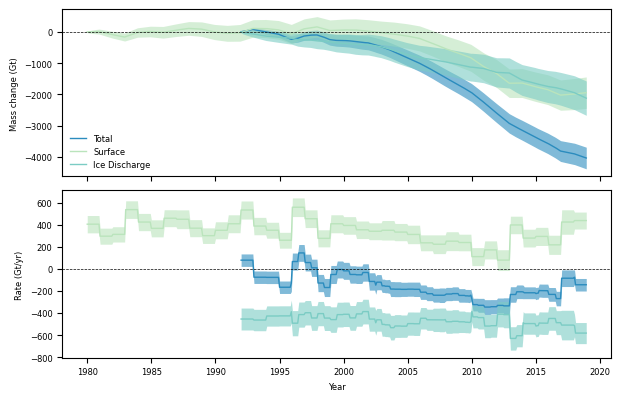

In [146]:
plot_obs(imbie_new)

In [ ]:
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 4))
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for m_var, m_u_var, m_color = zip([mass_varname, smb_varname, d_varname],
                                      [mass_uncertainty_varname, smb_uncertainty_varname, discharge_uncertainty_varname],
                                      [mass_color, smb_color, discharge_color]):
        print("hi")
        


In [130]:
imbie_new

,Year,Rate of ice sheet mass change (Gt/yr),Rate of ice sheet mass change uncertainty (Gt/yr),Cumulative ice sheet mass change (Gt),Cumulative ice sheet mass change uncertainty (Gt),Rate of surface mass balance anomaly (Gt/yr),Rate of surface mass balance uncertainty (Gt/yr),Cumulative surface mass balance anomaly (Gt),Cumulative surface mass balance anomaly uncertainty (Gt),Rate of ice discharge anomaly (Gt/yr),Rate of ice dynamics anomaly uncertainty (Gt/yr),Cumulative ice discharge anomaly (Gt),Cumulative ice discharge anomaly uncertainty (Gt),SMB (Gt/yr),D (Gt/yr),SLE (cm),SLE uncertainty (cm),Date
0,1980.000000,NaN,NaN,NaN,NaN,12.672691,78.709874,1.056058,22.721583,NaN,NaN,NaN,NaN,405.472691,NaN,NaN,NaN,1980-01-01 00:00:00.000000000
1,1980.083333,NaN,NaN,NaN,NaN,12.672691,78.709874,2.112115,32.133171,NaN,NaN,NaN,NaN,405.472691,NaN,NaN,NaN,1980-01-31 10:29:03.831122155
2,1980.166667,NaN,NaN,NaN,NaN,12.672691,78.709874,3.168173,39.354937,NaN,NaN,NaN,NaN,405.472691,NaN,NaN,NaN,1980-03-01 20:58:07.662552845
3,1980.250000,NaN,NaN,NaN,NaN,12.672691,78.709874,4.224230,45.443167,NaN,NaN,NaN,NaN,405.472691,NaN,NaN,NaN,1980-04-01 07:27:11.493675000
4,1980.333333,NaN,NaN,NaN,NaN,12.672691,78.709874,5.280288,50.807005,NaN,NaN,NaN,NaN,405.472691,NaN,NaN,NaN,1980-05-01 17:56:15.324797155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2018.583333,-143.8,56.8,-3991.865803,344.868007,45.653071,77.031700,-1961.451876,501.907312,-189.453071,95.70853,-2058.785224,547.081162,438.453071,-582.253071,1.101204,0.095136,2018-08-02 01:23:26.818472154
464,2018.666667,-143.8,56.8,-4003.849136,345.257579,45.653071,77.031700,-1957.647453,502.399682,-189.453071,95.70853,-2074.572980,547.778369,438.453071,-582.253071,1.104510,0.095243,2018-09-01 11:52:30.649902847
465,2018.750000,-143.8,56.8,-4015.832470,345.646711,45.653071,77.031700,-1953.843030,502.891569,-189.453071,95.70853,-2090.360736,548.474689,438.453071,-582.253071,1.107816,0.095351,2018-10-01 22:21:34.481024999
466,2018.833333,-143.8,56.8,-4027.815803,346.035406,45.653071,77.031700,-1950.038608,503.382976,-189.453071,95.70853,-2106.148492,549.170127,438.453071,-582.253071,1.111122,0.095458,2018-11-01 08:50:38.312147155


In [151]:


def load_mouginot(
    url: str = "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx",
    norm_year: float = 1992.0,
):
    """
    Load the Mouginot et al (2019) data set
    """

    dfs = []
    for basin, idx in zip(
        ["GIS", "SE", "CE", "NE", "NW", "CW", "SW"],
        [
            [7, 19, 29, 41],
            [6, 18, 28, 40],
            [5, 17, 27, 39],
            [4, 16, 26, 38],
            [3, 15, 25, 37],
            [2, 14, 24, 36],
            [1, 13, 23, 35],
        ],
    ):
        df_m = pd.read_excel(
            url,
            sheet_name="(2) MB_GIS",
            header=8,
            usecols="B,P:BJ",
            engine="openpyxl",
        )

        d = df_m.iloc[idx[0]]
        smb = df_m.iloc[idx[1]]
        mass = df_m.iloc[idx[3]]

        df_u = pd.read_excel(
            url,
            sheet_name="(2) MB_GIS",
            header=8,
            usecols="B,CE:DY",
            engine="openpyxl",
        )
        d_u = df_u.iloc[idx[0]]
        smb_u = df_u.iloc[idx[1]]
        mass_u = df_u.iloc[idx[2]]
        mass_uc = df_u.iloc[idx[3]]

        df = pd.DataFrame(
            data=np.hstack(
                [
                    df_m.columns[1::].values.reshape(-1, 1),
                    mass.values[1::].reshape(-1, 1),
                    smb.values[1::].reshape(-1, 1),
                    -d.values[1::].reshape(-1, 1),
                    mass_uc.values[1::].reshape(-1, 1),
                    smb_u.values[1::].reshape(-1, 1),
                    d_u.values[1::].reshape(-1, 1),
                ]
            ),
            columns=[
                "Year",
                "Cumulative ice sheet mass change (Gt)",
                "Rate of surface mass balance (Gt/yr)",
                "Rate of ice discharge (Gt/yr)",
                "Cumulative ice sheet mass change uncertainty (Gt)",
                "Rate of surface mass balance uncertainty (Gt/yr)",
                "Rate of ice discharge uncertainty (Gt/yr)",
            ],
        )
        df = df.astype(
            {
                "Year": float,
                "Cumulative ice sheet mass change (Gt)": float,
                "Cumulative ice sheet mass change uncertainty (Gt)": float,
                "Rate of surface mass balance (Gt/yr)": float,
                "Rate of surface mass balance uncertainty (Gt/yr)": float,
                "Rate of ice discharge (Gt/yr)": float,
                "Rate of ice discharge uncertainty (Gt/yr)": float,
            }
        )

        df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")

        # Normalize
        for v in [
            "Cumulative ice sheet mass change (Gt)",
        ]:
            df[v] -= df[df["Year"] == norm_year][v].values

        cmSLE = 1.0 / 362.5 / 10.0
        df["SLE (cm)"] = -df["Cumulative ice sheet mass change (Gt)"] * cmSLE
        df["SLE uncertainty (cm)"] = (
            -df["Cumulative ice sheet mass change uncertainty (Gt)"] * cmSLE
        )
        df["Basin"] = basin
        dfs.append(df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df


def load_mankoff(
    discharge_url: Union[str, Path] = Path(
        "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/gate_D.csv"
    ),
    discharge_error_url: Union[str, Path] = Path(
        "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/gate_err.csv"
    ),
):
    m_df = pd.read_csv(discharge_url, parse_dates=["Date"], infer_datetime_format=True)
    d_df = pd.read_csv(discharge_url, parse_dates=["Date"], infer_datetime_format=True)
    de_df = pd.read_csv(
        discharge_error_url, parse_dates=["Date"], infer_datetime_format=True
    )
    d_df = -d_df.drop(columns="Date").sum(axis=1)
    d_df.name = "Rate of ice discharge (Gt/yr)"
    de_df = de_df.drop(columns="Date").apply(np.square).sum(axis=1).apply(np.sqrt)
    de_df.name = "Rate of ice discharge uncertainty (Gt/yr)"
    df = pd.merge(d_df, de_df, left_index=True, right_index=True)
    df["Date"] = m_df["Date"]
    df["Year"] = [to_decimal_year(d) for d in df["Date"]]
    return df

In [152]:
man_new = load_mankoff()

In [153]:
man_new

,Rate of ice discharge (Gt/yr),Rate of ice discharge uncertainty (Gt/yr),Date,Year
0,-436.551631,4.966751,1986-04-15,1986.284932
1,-447.259029,5.441636,1986-05-15,1986.367123
2,-453.054380,5.418701,1986-06-15,1986.452055
3,-454.724618,5.431398,1986-07-15,1986.534247
4,-452.844580,5.385998,1986-08-15,1986.619178
...,...,...,...,...
2741,-498.549508,6.481403,2023-08-07,2023.597260
2742,-497.287553,6.480528,2023-08-10,2023.605479
2743,-497.287553,6.480528,2023-08-19,2023.630137
2744,-497.287553,6.480528,2023-08-31,2023.663014


In [180]:
mou_new = load_mouginot(norm_year=1992)

KeyError: 'Cumulative ice sheet mass change (Gt)'

In [155]:
plt.Fi

,Year,Cumulative ice sheet mass change (Gt),Rate of surface mass balance (Gt/yr),Rate of ice discharge (Gt/yr),Cumulative ice sheet mass change uncertainty (Gt),Rate of surface mass balance uncertainty (Gt/yr),Rate of ice discharge uncertainty (Gt/yr),Date,SLE (cm),SLE uncertainty (cm),Basin
0,1972.0,277.497805,501.71,-452.910591,69.468048,55.400612,41.911595,1972-01-01,-0.076551,-0.019164,GIS
1,1973.0,421.361211,596.77,-452.906594,96.893498,55.400612,38.643402,1973-01-01,-0.116238,-0.026729,GIS
2,1974.0,442.474116,474.43,-453.317096,117.176457,55.400612,35.675541,1974-01-01,-0.122062,-0.032325,GIS
3,1975.0,398.194005,410.21,-454.490111,133.753184,55.400612,33.020663,1975-01-01,-0.109847,-0.036897,GIS
4,1976.0,435.266159,493.80,-456.727845,148.005344,55.400612,30.764263,1976-01-01,-0.120073,-0.040829,GIS
...,...,...,...,...,...,...,...,...,...,...,...
324,2014.0,-567.846217,44.78,-91.247856,72.446996,8.317950,7.567393,2014-01-01,0.156647,-0.019985,SW
325,2015.0,-614.821968,41.91,-88.885751,73.299190,8.317950,7.417257,2015-01-01,0.169606,-0.020220,SW
326,2016.0,-650.251464,53.92,-89.349497,74.133138,8.317950,7.332306,2016-01-01,0.179380,-0.020451,SW
327,2017.0,-697.719858,34.36,-81.828394,74.866329,8.317950,6.329038,2017-01-01,0.192474,-0.020653,SW


In [161]:
def plot_observations(
    dfs: list[pd.DataFrame],
    sigma: float = 1,
    mass_varname: str = "Cumulative ice sheet mass change (Gt)",
    mass_uncertainty_varname: str = "Cumulative ice sheet mass change uncertainty (Gt)",
    smb_varname: str = "Cumulative surface mass balance anomaly (Gt)",
    smb_uncertainty_varname: str = "Cumulative surface mass balance anomaly uncertainty (Gt)",
    discharge_varname: str = "Cumulative ice discharge anomaly (Gt)",
    discharge_uncertainty_varname: str = "Cumulative ice discharge anomaly uncertainty (Gt)",
    mass_rate_varname: str = "Rate of ice sheet mass change (Gt/yr)",
    mass_rate_uncertainty_varname: str = "Rate of ice sheet mass change uncertainty (Gt/yr)",
    smb_rate_varname: str = "Rate of surface mass balance (Gt/yr)",
    smb_rate_uncertainty_varname: str = "Rate of surface mass balance uncertainty (Gt/yr)",
    discharge_rate_varname: str = "Rate of ice discharge (Gt/yr)",
    discharge_rate_uncertainty_varname: str = "Rate of ice discharge uncertainty (Gt/yr)",
    smb_color: str = "#bae4bc",
    discharge_color: str = "#7bccc4",
    mass_color: str = "#2b8cbe",
) -> plt.Figure:
    """Plot IMBIE time series"""
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 4))
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for df in dfs:
        for m_var, m_u_var, m_color, m_label in zip(
            [mass_varname, smb_varname, discharge_varname],
            [
                mass_uncertainty_varname,
                smb_uncertainty_varname,
                discharge_uncertainty_varname,
            ],
            [mass_color, smb_color, discharge_color],
            ["Total", "Surface", "Ice Discharge"],
        ):
            if (m_var and m_u_var) in df.columns:
                axs[0].fill_between(
                    df["Date"],
                    df[m_var] + sigma * df[m_u_var],
                    df[m_var] - sigma * df[m_u_var],
                    ls="solid",
                    lw=0,
                    alpha=0.6,
                    color=m_color,
                )
                axs[0].plot(df["Date"], df[m_var], lw=1, color=m_color, label=m_label)

        for m_var, m_u_var, m_color, m_label in zip(
            [mass_rate_varname, smb_rate_varname, discharge_rate_varname],
            [
                mass_rate_uncertainty_varname,
                smb_rate_uncertainty_varname,
                discharge_rate_uncertainty_varname,
            ],
            [mass_color, smb_color, discharge_color],
            ["Total", "Surface", "Ice Discharge"],
        ):
            if (m_var and m_u_var) in df.columns:
                axs[1].fill_between(
                    df["Date"],
                    df[m_var] + sigma * df[m_u_var],
                    df[m_var] - sigma * df[m_u_var],
                    ls="solid",
                    lw=0,
                    alpha=0.6,
                    color=m_color,
                )
                axs[1].plot(df["Date"], df[m_var], lw=1, color=m_color, label=m_label)

    axs[0].axhline(0, ls="dashed", color="k", lw=0.5)
    axs[1].axhline(0, ls="dashed", color="k", lw=0.5)
    axs[0].set_xlabel("")
    axs[0].set_ylabel("Mass change (Gt)")
    axs[1].set_xlabel("Year")
    axs[1].set_ylabel("Rate (Gt/yr)")
    legend = axs[0].legend()
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)
    fig.tight_layout()

    return fig


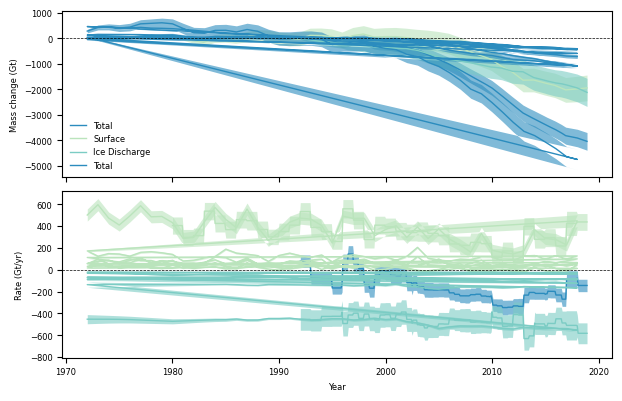

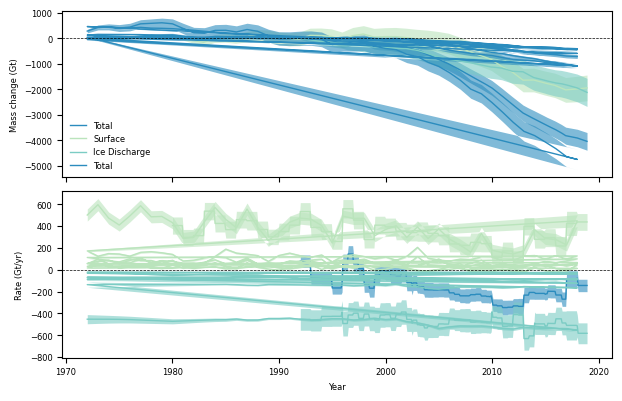

In [164]:
plot_observations([imbie_new, mou_new])

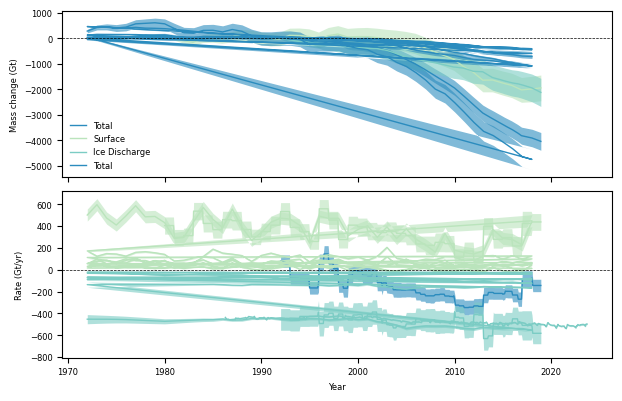

In [172]:
f = plot_observations([imbie_new, man_new, mou_new])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


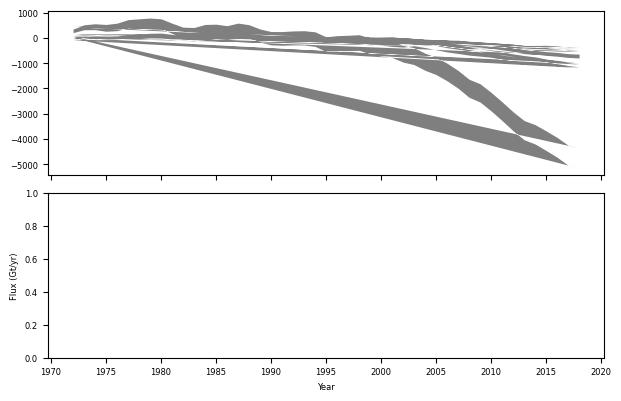

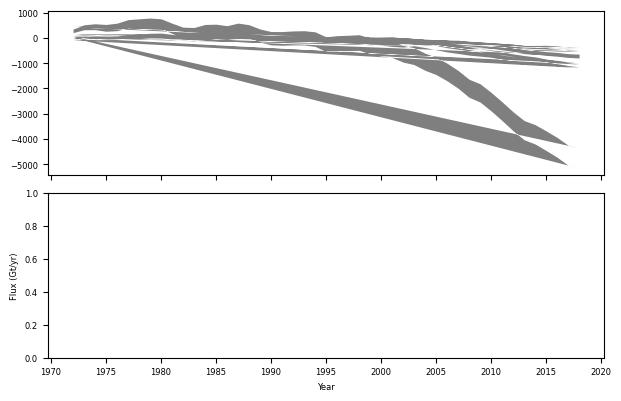

In [173]:
plot_imbie(mou_new)

KeyError: 'Cumulative surface mass balance anomaly (Gt)'

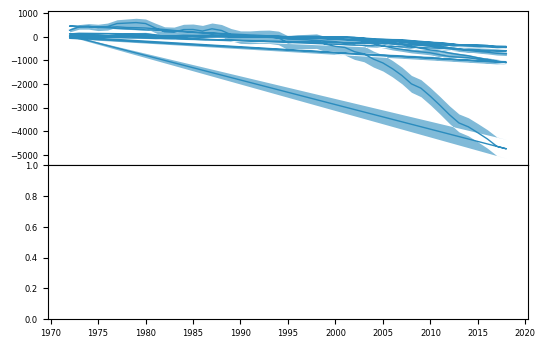

In [176]:
fig = plot_imbie(mou_new)

In [175]:
def plot_imbie(
    df: pd.DataFrame,
    sigma: float = 1,
    mass_varname: str = "Cumulative ice sheet mass change (Gt)",
    mass_uncertainty_varname: str = "Cumulative ice sheet mass change uncertainty (Gt)",
    smb_varname: str = "Cumulative surface mass balance anomaly (Gt)",
    smb_uncertainty_varname: str = "Cumulative surface mass balance anomaly uncertainty (Gt)",
    discharge_varname: str = "Cumulative ice discharge anomaly (Gt)",
    discharge_uncertainty_varname: str = "Cumulative ice discharge anomaly uncertainty (Gt)",
    mass_rate_varname: str = "Rate of ice sheet mass change (Gt/yr)",
    mass_rate_uncertainty_varname: str = "Rate of ice sheet mass change uncertainty (Gt/yr)",
    smb_rate_varname: str = "Rate of surface mass balance (Gt/yr)",
    smb_rate_uncertainty_varname: str = "Rate of surface mass balance uncertainty (Gt/yr)",
    discharge_rate_varname: str = "Rate of ice discharge (Gt/yr)",
    discharge_rate_uncertainty_varname: str = "Rate of ice discharge uncertainty (Gt/yr)",
    smb_color: str = "#bae4bc",
    discharge_color: str = "#7bccc4",
    mass_color: str = "#2b8cbe",
) -> plt.Figure:
    """Plot IMBIE time series"""
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 4))
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for m_var, m_u_var, m_color, m_label in zip(
        [mass_varname, smb_varname, discharge_varname],
        [
            mass_uncertainty_varname,
            smb_uncertainty_varname,
            discharge_uncertainty_varname,
        ],
        [mass_color, smb_color, discharge_color],
        ["Total", "Surface", "Ice Discharge"],
    ):
        axs[0].fill_between(
            df["Date"],
            df[m_var] + sigma * df[m_u_var],
            df[m_var] - sigma * df[m_u_var],
            ls="solid",
            lw=0,
            alpha=0.6,
            color=m_color,
        )
        axs[0].plot(df["Date"], df[m_var], lw=1, color=m_color, label=m_label)

    for m_var, m_u_var, m_color, m_label in zip(
        [mass_rate_varname, smb_rate_varname, discharge_rate_varname],
        [
            mass_rate_uncertainty_varname,
            smb_rate_uncertainty_varname,
            discharge_rate_uncertainty_varname,
        ],
        [mass_color, smb_color, discharge_color],
        ["Total", "Surface", "Ice Discharge"],
    ):
        axs[1].fill_between(
            df["Date"],
            df[m_var] + sigma * df[m_u_var],
            df[m_var] - sigma * df[m_u_var],
            ls="solid",
            lw=0,
            alpha=0.6,
            color=m_color,
        )
        axs[1].plot(df["Date"], df[m_var], lw=1, color=m_color, label=m_label)

    axs[0].axhline(0, ls="dashed", color="k", lw=0.5)
    axs[1].axhline(0, ls="dashed", color="k", lw=0.5)
    axs[0].set_xlabel("")
    axs[0].set_ylabel("Mass change (Gt)")
    axs[1].set_xlabel("Year")
    axs[1].set_ylabel("Rate (Gt/yr)")
    legend = axs[0].legend()
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)
    fig.tight_layout()

    return fig



In [179]:
def load_mouginot(
    url: str = "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx",
    norm_year: float = 1992.0,
):
    """
    Load the Mouginot et al (2019) data set
    """

    dfs = []
    for basin, idx in zip(
        ["GIS", "SE", "CE", "NE", "NW", "CW", "SW"],
        [
            [7, 19, 29, 41],
            [6, 18, 28, 40],
            [5, 17, 27, 39],
            [4, 16, 26, 38],
            [3, 15, 25, 37],
            [2, 14, 24, 36],
            [1, 13, 23, 35],
        ],
    ):
        df_m = pd.read_excel(
            url,
            sheet_name="(2) MB_GIS",
            header=8,
            usecols="B,P:BJ",
            engine="openpyxl",
        )

        d_rate = df_m.iloc[idx[0]]
        smb_rate = df_m.iloc[idx[1]]
        mass_rate = df_m.iloc[idx[3]]

        df_u = pd.read_excel(
            url,
            sheet_name="(2) MB_GIS",
            header=8,
            usecols="B,CE:DY",
            engine="openpyxl",
        )
        d_u = df_u.iloc[idx[0]]
        smb_u = df_u.iloc[idx[1]]
        mass_u = df_u.iloc[idx[2]]
        mass_uc = df_u.iloc[idx[3]]

        df = pd.DataFrame(
            data=np.hstack(
                [
                    df_m.columns[1::].values.reshape(-1, 1),
                    mass_rate.values[1::].reshape(-1, 1),
                    smb_rate.values[1::].reshape(-1, 1),
                    -d_rate.values[1::].reshape(-1, 1),
                    mass_uc.values[1::].reshape(-1, 1),
                    smb_u.values[1::].reshape(-1, 1),
                    d_u.values[1::].reshape(-1, 1),
                ]
            ),
            columns=[
                "Year",
                "Rate of ice sheet mass change (Gt/yr)",
                "Rate of surface mass balance (Gt/yr)",
                "Rate of ice discharge (Gt/yr)",
                "Rate of ice sheet mass change uncertainty (Gt/yr)",
                "Rate of surface mass balance uncertainty (Gt/yr)",
                "Rate of ice discharge uncertainty (Gt/yr)",
            ],
        )
        df = df.astype(
            {
                "Year": float,
                "Rate of ice sheet mass change (Gt/yr)": float,
                "Rate of ice sheet mass change uncertainty (Gt/yr)": float,
                "Rate of surface mass balance (Gt/yr)": float,
                "Rate of surface mass balance uncertainty (Gt/yr)": float,
                "Rate of ice discharge (Gt/yr)": float,
                "Rate of ice discharge uncertainty (Gt/yr)": float,
            }
        )

        df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")

        # Normalize
        for v in [
            "Cumulative ice sheet mass change (Gt)",
        ]:
            df[v] -= df[df["Year"] == norm_year][v].values

        cmSLE = 1.0 / 362.5 / 10.0
        df["SLE (cm)"] = -df["Cumulative ice sheet mass change (Gt)"] * cmSLE
        df["SLE uncertainty (cm)"] = (
            -df["Cumulative ice sheet mass change uncertainty (Gt)"] * cmSLE
        )
        df["Basin"] = basin
        dfs.append(df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df


In [184]:
    url: str = "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx"
    norm_year: float = 1992.0


In [185]:
        df_m = pd.read_excel(
            url,
            sheet_name="(2) MB_GIS",
            header=8,
            usecols="B,P:BJ",
            engine="openpyxl",
        )


In [183]:
url

('/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx',)

In [192]:
df_m[0:8]

,D,1972,1973,1974,1975,1976,1977,1978,1979,1980,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,SW,29.715688,29.715688,29.715688,29.715688,29.715688,29.715688,29.715688,29.715688,29.715688,...,29.898892,30.249253,32.06769,32.27278,29.515989,30.299222,30.233291,31.585737,29.848878,30.696075
1,CW,68.519302,68.519302,68.519302,68.519302,68.519302,68.271699,68.034231,67.814928,67.568018,...,86.767062,91.297146,87.538613,91.437684,93.484106,91.247856,88.885751,89.349497,81.828394,78.278311
2,NW,89.637047,89.637047,89.506731,90.126923,90.724697,90.916017,91.112696,91.311308,91.508918,...,100.247404,101.979766,110.15801,111.381046,105.885306,111.03429,114.488462,113.075877,119.133436,123.962766
3,NO,23.380782,23.380782,23.380782,23.380782,23.356830,23.328745,23.304793,23.280840,23.256888,...,21.562641,21.820675,22.977543,23.128028,25.22125,24.461357,23.895909,23.763902,24.251631,25.939927
4,NE,31.000983,31.000983,31.781109,32.572949,34.474940,38.680635,42.903717,47.125256,51.335081,...,30.721933,31.979385,32.61931,34.643153,32.430754,34.767316,36.067037,36.391143,36.455061,39.485525
5,CE,74.534759,74.530763,74.530763,74.530763,74.530763,74.530763,74.530763,74.530763,74.526766,...,87.503553,86.076541,87.912466,89.265477,85.478711,86.063992,84.579602,84.213083,87.597076,90.912482
6,SE,136.122029,136.122029,135.882720,135.643704,135.405626,135.145135,134.907057,134.669937,134.428731,...,158.997158,160.53997,164.182701,161.131749,153.708243,155.736116,160.736778,159.895625,160.831412,165.840435
7,GIS,452.910591,452.906594,453.317096,454.490111,456.727845,460.588681,464.508945,468.448720,472.340091,...,515.698643,523.942737,537.456333,543.259916,525.72436,533.610148,538.886831,538.274865,539.945889,555.115522


In [191]:
df_m[12:20]

,D,1972,1973,1974,1975,1976,1977,1978,1979,1980,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
12,SW,55.15,95.22,32.42,30.79,57.71,60.57,59.78,82.17,21.55,...,46.86,-38.68,-59.21,-40.15,-19.66,29.14,5.73,-0.57,-32.28,40.98
13,CW,55.33,96.16,55.45,62.90,63.45,101.11,67.99,80.59,46.96,...,54.61,38.73,26.91,26.77,36.6,44.78,41.91,53.92,34.36,58.55
14,NW,58.38,76.30,89.40,57.15,86.06,111.40,60.79,84.10,77.86,...,24.79,29.72,60.19,31.43,41.61,56.08,29.81,39.16,49.18,66.70
15,NO,16.57,44.72,38.29,16.39,23.80,34.58,14.80,14.41,15.03,...,-8.95,-15.2,4.06,-17.76,-17.4,17.96,-8.58,-20.98,4.26,12.56
16,NE,31.74,60.58,28.09,27.03,36.87,35.21,32.05,13.23,43.16,...,9.66,8.56,-5.92,11.98,-20.19,33.71,42.5,10.49,-11.01,44.14
17,CE,112.86,100.13,82.77,72.48,100.90,85.25,85.19,59.20,87.12,...,86.94,36.6,47.61,46.91,27.07,54.93,77.26,64.60,82.64,99.64
18,SE,173.02,124.41,148.82,144.39,125.33,159.96,166.00,156.03,140.93,...,118.86,118.05,83.62,85.43,126.97,130.86,98.41,128.98,99.10,126.43
19,GIS,501.71,596.77,474.43,410.21,493.80,587.32,485.56,488.95,432.16,...,333.05,178.67,158.49,145.54,175.36,367.54,287.49,276.02,227.10,449.00
